# Use LeNet to perform image classification on the MNIST Dataset

The MNIST dataset consists of 28x28 grayscale images. 

Key concepts illustrated

 * Basic structure of a CNN

 * Convolutional layer

 * Max pooling layer

 * Pre-processing tools in `torchvision.transforms`

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns

## Load the internal data from `torchvision.datasets`

In [2]:
train_data = datasets.MNIST(root = '.data', train = True, download=True, transform = transforms.ToTensor())
test_data  = datasets.MNIST(root = '.data', train = False, download=True, transform = transforms.ToTensor())

In [3]:
print(train_data)
print(train_data.data.shape)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])


In [4]:
print(test_data)
print(test_data.data.shape)

Dataset MNIST
    Number of datapoints: 10000
    Root location: .data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([10000, 28, 28])


In [5]:
class_names = train_data.class_to_idx
print(class_names)
class_idx_to_names = dict([(j,i) for i,j in class_names.items()])
print(class_idx_to_names)

{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}
{0: '0 - zero', 1: '1 - one', 2: '2 - two', 3: '3 - three', 4: '4 - four', 5: '5 - five', 6: '6 - six', 7: '7 - seven', 8: '8 - eight', 9: '9 - nine'}


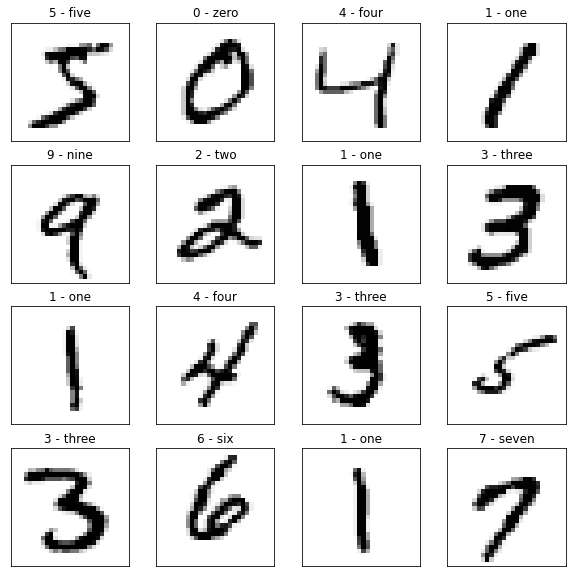

In [6]:
def img_plotter(img_list, lab_list):
    ncols = 4
    nrows = int(np.ceil(len(img_list)/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5))
    for i in range(len(img_list)):
        image = img_list[i]
        label = lab_list[i]
        ax = axes.flat[i]
        if len(image.shape) == 3:
            ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        else:
            ax.imshow(image.numpy())
        ax.set_title(label)
        ax.set_xticks([])
        ax.set_yticks([])

# View the first few images
count = 0
img_list = []
lab_list = []
for image, label in train_data:
    img_list.append(image[0,:,:])
    lab_list.append(class_idx_to_names[label])
    count += 1
    if count >= 16:
        break

img_plotter(img_list, lab_list)

## Pre-processing

In [7]:
torch.manual_seed(999)

# split into training and test sets
batch_size = 100
train_iterator = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_iterator = DataLoader(test_data, shuffle=False, batch_size=batch_size)

## Define the LeNet Model

In [8]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 6, 5, 1, 2) # in_channels, out_channels, kernel_size, stride, padding
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_dim)

    def forward(self, x):
        x = F.sigmoid(self.conv1(x))
        x = F.max_pool2d(x, 2, 2) # kernel_size, stride # 28x28x1 -> 14x14x6
        x = F.sigmoid(self.conv2(x))
        x = F.max_pool2d(x, 2, 2) # kernel_size, stride # 14x14x6 -> ((14+0-5)/2+1)x((14+0-5)/2+1)x16
        x = x.view(-1, 16*5*5)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

## Instantiate the model, define loss and optimization functions

In [9]:
model = LeNet(len(class_names))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 20

def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

   150
     6
  2400
    16
 48000
   120
 10080
    84
   840
    10
______
 61706


## Train the Model

In [10]:
start_time = time.time()

train_losses = []

for i in range(num_epochs):
    for j, (img_list, lab_list) in enumerate(train_iterator):

        lab_pred = model(img_list)
        loss = criterion(lab_pred, lab_list)

        if j%10000 == 0:
            print(f'epoch: {i:2}  batch: {j:4} [{batch_size*j:6}/50000]  loss: {loss.item():10.8f}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed


C:\Users\ywang254\Anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:  0  batch:    0 [     0/50000]  loss: 2.35071707
epoch:  1  batch:    0 [     0/50000]  loss: 0.53825521
epoch:  2  batch:    0 [     0/50000]  loss: 0.21643020
epoch:  3  batch:    0 [     0/50000]  loss: 0.18339114
epoch:  4  batch:    0 [     0/50000]  loss: 0.14424619
epoch:  5  batch:    0 [     0/50000]  loss: 0.23233528
epoch:  6  batch:    0 [     0/50000]  loss: 0.16187423
epoch:  7  batch:    0 [     0/50000]  loss: 0.06077901
epoch:  8  batch:    0 [     0/50000]  loss: 0.11184392
epoch:  9  batch:    0 [     0/50000]  loss: 0.00618383
epoch: 10  batch:    0 [     0/50000]  loss: 0.10775263
epoch: 11  batch:    0 [     0/50000]  loss: 0.05257332
epoch: 12  batch:    0 [     0/50000]  loss: 0.10071319
epoch: 13  batch:    0 [     0/50000]  loss: 0.00952432
epoch: 14  batch:    0 [     0/50000]  loss: 0.07218184
epoch: 15  batch:    0 [     0/50000]  loss: 0.03712070
epoch: 16  batch:    0 [     0/50000]  loss: 0.05011184
epoch: 17  batch:    0 [     0/50000]  loss: 0.0

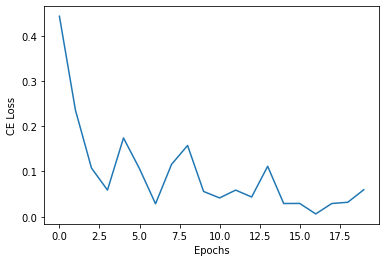

In [11]:
num_epochs = len(train_losses)
if num_epochs == len(train_losses):
    plt.plot(torch.Tensor(train_losses).detach().numpy())
    plt.xlabel('Epochs')
    plt.ylabel('CE Loss')
else:
    raise 'Training is not finished.'

In [12]:
# save the trained model
torch.save(model.state_dict(), 'LeNet_MNIST.pt')

## Evaluate the model

In [13]:
model2 = LeNet(10)
model2.load_state_dict(torch.load('LeNet_MNIST.pt'))

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
def calc_accuracy(y_pred, y):
    which = y_pred.argmax(1)
    correct = (which == y).float().mean() * 100
    return correct

start_time = time.time()

test_losses = []
test_accuracy = []

model2.eval()

with torch.no_grad():
    for j, (img_list, lab_list) in enumerate(test_iterator):
        lab_pred = model2(img_list)

        loss = criterion(lab_pred, lab_list)
        test_losses.append(loss)

        acc = calc_accuracy(lab_pred, lab_list)
        test_accuracy.append(acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

C:\Users\ywang254\Anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Duration: 4 seconds


Text(0, 0.5, 'CE Loss')

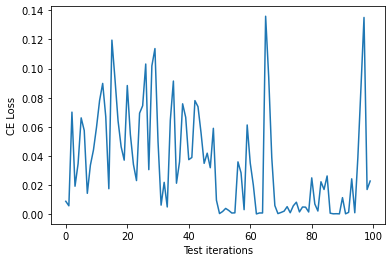

In [15]:
plt.plot(torch.Tensor(test_losses).detach().numpy())
plt.xlabel('Test iterations')
plt.ylabel('CE Loss')

Text(0, 0.5, 'Correct classifications (%)')

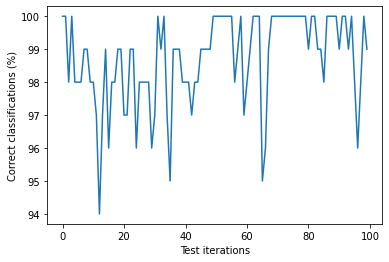

In [16]:
plt.plot(torch.Tensor(test_accuracy).detach().numpy())
plt.xlabel('Test iterations')
plt.ylabel('Correct classifications (%)')

Make the confusion matrix using all of the test data

In [17]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    for X_test, y_test in test_load_all:
        test_pred_all = model(X_test)

C:\Users\ywang254\Anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


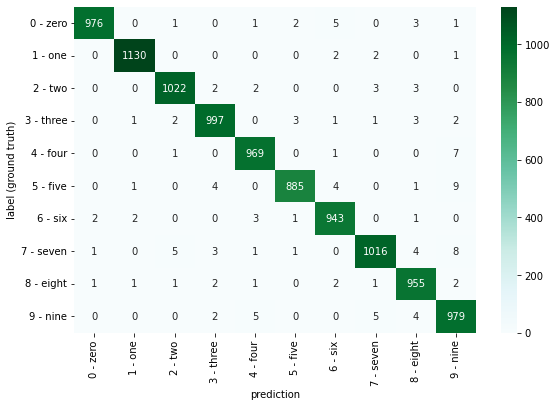

In [18]:
arr = confusion_matrix(test_pred_all.argmax(1), y_test.detach().numpy())

df_cm = pd.DataFrame(arr, [class_idx_to_names[i] for i in range(10)], [class_idx_to_names[i] for i in range(10)])
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()